In [172]:
# Calculate fairness metrics using custom functions

#Import necessary packages
import numpy as np
np.random.seed(88)
import pandas as pd
import random
random.seed(88)
import matplotlib.pyplot as plt
import shap
import copy,math
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import sklearn.metrics as pm
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Activate the custom functions (Chakraborty et al., 2021)
import os
import sys
sys.path.append(os.path.abspath('..'))

from Generate_Samples import generate_samples # Fair-SMOTE package
from Measure import measure_final_score


# Function for the dashboard. With this function, the right SHAP explainer will be chosen.
def experiment(option='LogisticRegression', seed='None'):
    if option == 'LogisticRegression':
        classifier = LogisticRegression(random_state=seed)
        n_shap_explainer = 'LogisticRegression'
        name = 'LogisticRegression','+FairSMOTE'
    elif option == 'SVC':
        classifier = SVC(C=100, probability=True, random_state=seed)
        n_shap_explainer = 'SVC'
        name = 'LogisticRegression','+FairSMOTE'
    elif option == 'RandomForest':
        classifier = RandomForestClassifier(n_estimators=100, random_state=seed)
        n_shap_explainer = 'RandomForestClassifier'
        name = 'RandomForestClassifier','+FairSMOTE'
    elif option == 'MLPClassifier':
        classifier = MLPClassifier(random_state=seed)
        n_shap_explainer = 'MLPClassifier'
        name = 'MLPClassifier','+FairSMOTE'
    else:
        experiment('LogisticRegression',seed='None')
    return classifier, n_shap_explainer, name


In [173]:
# Load the German Credit Dataset

df = pd.read_csv("statlogGermanCreditData_float.csv") # load dataset
df = df.loc[:,df.columns!='statussex'] # drop variable 'statussex', because we have derived the statussex variable. The marital status variable is useless because we cannot extract info from this variable
df = df[['existingchecking', 'maritalStatus', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'sex', 'installmentrate', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']] #sort variables to this format
df

,existingchecking,maritalStatus,duration,credithistory,purpose,creditamount,savings,employmentsince,sex,installmentrate,...,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,classification
0,1,0,6,3,3,1169,3,2,1,4,...,1,67,0,1,2,2,1,1,1,1
1,2,1,48,1,3,5951,1,1,0,2,...,1,22,0,1,1,2,1,0,1,0
2,0,0,12,3,6,2096,1,2,1,2,...,1,49,0,1,1,1,2,0,1,1
3,1,0,42,1,2,7882,1,2,1,2,...,2,45,0,2,1,2,2,0,1,1
4,1,0,24,2,1,4870,1,1,1,3,...,0,53,0,2,2,2,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,12,1,2,1736,1,2,0,3,...,1,31,0,1,1,1,1,0,1,1
996,1,1,30,1,1,3857,1,1,1,4,...,2,40,0,1,1,3,1,1,1,1
997,0,0,12,1,3,804,1,2,1,4,...,3,38,0,1,1,2,1,0,1,1
998,1,0,45,1,3,1845,1,1,1,4,...,0,23,0,2,1,2,1,1,1,0


In [174]:
# Specify params
seed = 88
smote_k=5
cv = 5
shap_k=8 


# select target variable and protected attribute
target_variable = 'classification' # this the target (or y-) variable
protected_attribute = 'sex' # this is the variable to make comparisons with

#specify categorical variables, for one-hot-encoding except the protected variable!!!
categorical_variables = ['existingchecking','credithistory','purpose','savings','employmentsince','otherdebtors','property','otherinstallmentplans','housing','job','telephone','foreignworker']

#specify ratio variables for MinMaxScaler() # source: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data
ratio_variables = ['duration','creditamount','installmentrate','residencesince','age','existingcredits', 'peopleliable']

# all other variables are ignored automatically.

#fair-smote: specify dataset for the generation function. it is called 'German'.
# If not specified, please replace this to 'None', then it will automatically take the columns
dataset_smo = 'None'

# Oversampling technique
# Which oversampling technique? Choose either RandomOverSampler() or SMOTE()
#sampler = RandomOverSampler(sampling_strategy='minority', random_state=seed)
sampler = SMOTE(sampling_strategy='minority', random_state=seed, k_neighbors=smote_k)

# Choice: which classifier? Just choose one. We need the variables in a tuple form, or we run error
#classifier, n_shap_explainer, name = experiment('LogisticRegression',seed=seed)
#classifier, n_shap_explainer, name = experiment('SVC',seed=seed)
#classifier, n_shap_explainer, name = experiment('RandomForest',seed=seed)
classifier, n_shap_explainer, name = experiment('MLPClassifier',seed=seed)

# ------- From this line, don't change anything -------- #


<b>Feature selection</b>

In [175]:
# Apply one hot encoding on categorical variables
df_categorical = pd.DataFrame(df, columns=categorical_variables)
df_categorical = pd.get_dummies(df_categorical, columns =categorical_variables, drop_first=True)

df_categorical = df_categorical * 1 # make booleans into one's and zero's for respectively True and False
df_categorical
categorical_columns = df_categorical.columns

In [176]:
# interval and ratio variables will be coded with scaler, weights are better trained
df_ratio = df[ratio_variables]
scaler = MinMaxScaler()
df_ratio = scaler.fit_transform(df_ratio)
df_ratio = pd.DataFrame(df_ratio, columns=ratio_variables)


In [177]:
# Merge datasets. Please check before proceeding to splitting the dataset into a training and test set & pre-processing steps.

df_concat_1 = pd.merge(df_ratio, df[protected_attribute], left_index=True, right_index=True)
df_concat_2 = pd.merge(df_concat_1, df_categorical, left_index=True, right_index=True)
df_concat_3 = pd.merge(df_concat_2, df[target_variable], left_index=True, right_index=True)
df = df_concat_3
df


,duration,creditamount,installmentrate,residencesince,age,existingcredits,peopleliable,sex,existingchecking_1,existingchecking_2,...,otherinstallmentplans_1,otherinstallmentplans_2,housing_1,housing_2,job_1,job_2,job_3,telephone_1,foreignworker_1,classification
0,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0,1,1,0,...,0,0,1,0,0,1,0,1,1,1
1,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
2,0.117647,0.101574,0.333333,0.666667,0.535714,0.000000,1.0,1,0,0,...,0,0,1,0,1,0,0,0,1,1
3,0.558824,0.419941,0.333333,1.000000,0.464286,0.000000,1.0,1,1,0,...,0,0,0,1,0,1,0,0,1,1
4,0.294118,0.254209,0.666667,1.000000,0.607143,0.333333,1.0,1,1,0,...,0,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.117647,0.081765,0.666667,1.000000,0.214286,0.000000,0.0,0,0,0,...,0,0,1,0,1,0,0,0,1,1
996,0.382353,0.198470,1.000000,1.000000,0.375000,0.000000,0.0,1,1,0,...,0,0,1,0,0,0,1,1,1,1
997,0.117647,0.030483,1.000000,1.000000,0.339286,0.000000,0.0,1,0,0,...,0,0,1,0,0,1,0,0,1,1
998,0.602941,0.087763,1.000000,1.000000,0.071429,0.000000,0.0,1,1,0,...,0,0,0,1,0,1,0,1,1,0


In [178]:
# to save memory, delete  temporary df
del df_categorical
del df_ratio
del df_concat_1
del df_concat_2
del df_concat_3

#df_with = pd.get_dummies(df, columns=categorical_variables, drop_first=False)
columns = df.columns # for later use we need to derive the df columns

#Inspect dataframe
df

,duration,creditamount,installmentrate,residencesince,age,existingcredits,peopleliable,sex,existingchecking_1,existingchecking_2,...,otherinstallmentplans_1,otherinstallmentplans_2,housing_1,housing_2,job_1,job_2,job_3,telephone_1,foreignworker_1,classification
0,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0,1,1,0,...,0,0,1,0,0,1,0,1,1,1
1,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
2,0.117647,0.101574,0.333333,0.666667,0.535714,0.000000,1.0,1,0,0,...,0,0,1,0,1,0,0,0,1,1
3,0.558824,0.419941,0.333333,1.000000,0.464286,0.000000,1.0,1,1,0,...,0,0,0,1,0,1,0,0,1,1
4,0.294118,0.254209,0.666667,1.000000,0.607143,0.333333,1.0,1,1,0,...,0,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.117647,0.081765,0.666667,1.000000,0.214286,0.000000,0.0,0,0,0,...,0,0,1,0,1,0,0,0,1,1
996,0.382353,0.198470,1.000000,1.000000,0.375000,0.000000,0.0,1,1,0,...,0,0,1,0,0,0,1,1,1,1
997,0.117647,0.030483,1.000000,1.000000,0.339286,0.000000,0.0,1,0,0,...,0,0,1,0,0,1,0,0,1,1
998,0.602941,0.087763,1.000000,1.000000,0.071429,0.000000,0.0,1,1,0,...,0,0,0,1,0,1,0,1,1,0


In [179]:
# Split the dataset in a training and test set.

kf = KFold(n_splits=cv, shuffle=True, random_state=seed)
k = kf.get_n_splits()

acc_score = []

X, y = df.loc[:, df.columns != target_variable], df[target_variable]
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    classifier.fit(X_train, y_train)
    pred_values = classifier.predict(X_test)
     
    acc = pm.accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

dataset_orig_test = pd.merge(X_test, y_test, left_index=True, right_index=True)
dataset_orig_train = pd.merge(X_train, y_train, left_index=True, right_index=True)

sort_by_columns = dataset_orig_train.columns # Save the order of the column variable

/Users/kawai/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kawai/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kawai/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kawai/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


accuracy of each fold - [0.765, 0.74, 0.75, 0.74, 0.75]
Avg accuracy : 0.749


/Users/kawai/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<b>Oversampling strategy</b>
Here it is either, RandomOversampler(), SMOTE().</br>
For Fair-SMOTE, we use the SMOTE() function and evaluate it based on AOD and EOD, according to the paper of Chakraborty et al.</br>

In [180]:
# --- begin RandomOversampler or SMOTE
# Please consult the dashboard. Modify 'sampler' variable.


X_train, y_train = sampler.fit_resample(X_train, y_train)

# Print the class distribution before and after resampling

print("Class distribution before oversampling strategy:")
print(f"Resampled dataset shape: {Counter(y_train)}")

print("\nClass distribution after oversampling strategy:")
print(f"Resampled dataset shape: {Counter(y_train)}")
print("The resampled version of the training set will be used for training.")
# --- end RandomOversampler or SMOTE procedure

Class distribution before oversampling strategy:
Resampled dataset shape: Counter({1: 553, 0: 553})

Class distribution after oversampling strategy:
Resampled dataset shape: Counter({1: 553, 0: 553})
The resampled version of the training set will be used for training.


In [181]:
# check scores after resampling the training set (report for RQ1)
aod = measure_final_score(dataset_orig_test, classifier, X_train, y_train, X_test, y_test, protected_attribute, metric='aod')
fprd=measure_final_score(dataset_orig_test, classifier, X_train, y_train, X_test, y_test, protected_attribute, metric='FPR')
tprd=measure_final_score(dataset_orig_test, classifier, X_train, y_train, X_test, y_test, protected_attribute, metric='TPR')
eod=measure_final_score(dataset_orig_test, classifier, X_train, y_train, X_test, y_test, protected_attribute, metric='eod')
di=measure_final_score(dataset_orig_test, classifier, X_train, y_train, X_test, y_test, protected_attribute, metric='DI')
spd= measure_final_score(dataset_orig_test, classifier, X_train, y_train, X_test, y_test, protected_attribute, metric='SPD')

print('Fairness scores after pre-processing:')
print('\n\nAverage Odds Difference (AOD) for',protected_attribute,':',aod)
print('\nFalse Positive Rate difference (FPRd):',fprd)
print('\nTrue Positive Rate difference (TPRd):',tprd)
print('\nEqual Opportunity Difference (EOD) for',protected_attribute,':',eod)
print('\nDisparate Impact:',di)
print('\nStatistical Parity Difference:',spd)

/Users/kawai/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kawai/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kawai/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kawai/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kawai/opt/anacond

Fairness scores after pre-processing:


Average Odds Difference (AOD) for sex : -0.02

False Positive Rate difference (FPRd): -0.31

True Positive Rate difference (TPRd): 0.27

Equal Opportunity Difference (EOD) for sex : 0.27

Disparate Impact: 0.63

Statistical Parity Difference: 0.31


/Users/kawai/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<b>Classification</b></br>

In [182]:
# The classifier is a Logistic Regression
#Specify 'classifier' in the dashboard above
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


/Users/kawai/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [183]:
TP, TN, FP, FN = pm.confusion_matrix(y_test, y_pred).ravel()

In [184]:
pm.confusion_matrix(y_test, y_pred)

array([[ 23,  30],
       [ 30, 117]])

In [185]:
# *** Fairness *** Functions *** #
# We split the sensitive variables into 
# The pseudo-code and code inspired from Chakraborty et al. (2017) Fair-SMOTE paper

#First, we deep copy the test set dataframe
test_set_copy = copy.deepcopy(X_test)

#Second, we add the real truth of the test set
test_set_copy['classification'] = y_test

# Create column 'predicted' at the test set
test_set_copy['current_pred_classification'] = y_pred

In [186]:
# Split TP/TN/FN/FP from males and females (Chakraborty et al., 2017)

# how to read the np.where statement?
# First, the sex. Sex = 1 is male, while sex = 0 is female.
# Second, the y_pred is matched with the y_true. one is one, and zero is zero.
# If the conditions is satisfied, then you have to read the thing after the comma.
# the named column gets a 1, else it is a 0.


# True Positive Male
test_set_copy['TP_classification_1'] = np.where((test_set_copy[protected_attribute] == 1) & (test_set_copy['current_pred_classification'] == 1)
& (test_set_copy['classification'] == 1), 1, 0)

# True Positive Female
test_set_copy['TP_classification_0'] = np.where((test_set_copy[protected_attribute] == 0) & (test_set_copy['current_pred_classification'] == 1)
& (test_set_copy['classification'] == 1), 1, 0)

# True Negative Male
test_set_copy['TN_classification_1'] = np.where((test_set_copy[protected_attribute] == 1) & (test_set_copy['current_pred_classification'] == 0)
& (test_set_copy['classification'] == 0), 1, 0)

# True Negative Female
test_set_copy['TN_classification_0'] = np.where((test_set_copy[protected_attribute] == 0) & (test_set_copy['current_pred_classification'] == 0)
& (test_set_copy['classification'] == 0), 1, 0)

# False Positive Male (type 1)
test_set_copy['FP_classification_1'] = np.where((test_set_copy[protected_attribute] == 1) & (test_set_copy['current_pred_classification'] == 1)
& (test_set_copy['classification'] == 0), 1, 0)

# False positive female (type 1)
test_set_copy['FP_classification_0'] = np.where((test_set_copy[protected_attribute] == 0) & (test_set_copy['current_pred_classification'] == 1)
& (test_set_copy['classification'] == 0), 1, 0)

# False Negative Male (type 2)
test_set_copy['FN_classification_1'] = np.where((test_set_copy[protected_attribute] == 1) & (test_set_copy['current_pred_classification'] == 0)
& (test_set_copy['classification'] == 1), 1, 0)

# False Negative Female (type 2)
test_set_copy['FN_classification_0'] = np.where((test_set_copy[protected_attribute] == 0) & (test_set_copy['current_pred_classification'] == 0)
& (test_set_copy['classification'] == 1), 1, 0)

In [187]:
# We split the TN/TP/FP/FN of males and females and store them into variables a to h.
# With this, we split the confusion matrix between people from the protected attributes.
a = test_set_copy['TP_classification_1'].sum()
b = test_set_copy['TN_classification_1'].sum()
c = test_set_copy['FN_classification_1'].sum()
d = test_set_copy['FP_classification_1'].sum()
e = test_set_copy['TP_classification_0'].sum()
f = test_set_copy['TN_classification_0'].sum()
g = test_set_copy['FN_classification_0'].sum()
h = test_set_copy['FP_classification_0'].sum()

In [188]:
# For the formulas, we need to formulate functions to calculate metrics.
# This is from the Measure.py functions from Chakraborty et al. 
# Here we have the functions
def calculate_average_odds_difference(TP_male , TN_male, FN_male,FP_male, TP_female , TN_female , FN_female,  FP_female):
    # TPR_male = TP_male/(TP_male+FN_male)
    # TPR_female = TP_female/(TP_female+FN_female)
    # FPR_male = FP_male/(FP_male+TN_male)
    # FPR_female = FP_female/(FP_female+TN_female)
    # average_odds_difference = abs(abs(TPR_male - TPR_female) + abs(FPR_male - FPR_female))/2
    FPR_diff = calculate_FPR_difference(TP_male , TN_male, FN_male,FP_male, TP_female , TN_female , FN_female,  FP_female)
    TPR_diff = calculate_TPR_difference(TP_male , TN_male, FN_male,FP_male, TP_female , TN_female , FN_female,  FP_female)
    average_odds_difference = (FPR_diff + TPR_diff)/2
    #print("average_odds_difference",average_odds_difference)
    return round(average_odds_difference,4)

def calculate_Disparate_Impact(TP_male , TN_male, FN_male,FP_male, TP_female , TN_female , FN_female,  FP_female):
    P_male = (TP_male + FP_male)/(TP_male + TN_male + FN_male + FP_male)
    P_female = (TP_female + FP_female)/(TP_female + TN_female + FN_female +  FP_female)    
    DI = (P_female/P_male)
    return round((1 - abs(DI)),4)

def calculate_SPD(TP_male , TN_male, FN_male,FP_male, TP_female , TN_female , FN_female,  FP_female):
    P_male = (TP_male + FP_male)/(TP_male + TN_male + FN_male + FP_male)
    P_female = (TP_female + FP_female) /(TP_female + TN_female + FN_female +  FP_female)       
    SPD = (P_female - P_male)
    return round(abs(SPD),4)


def calculate_equal_opportunity_difference(TP_male , TN_male, FN_male,FP_male, TP_female , TN_female , FN_female,  FP_female):
    # TPR_male = TP_male/(TP_male+FN_male)
    # TPR_female = TP_female/(TP_female+FN_female)    
    # equal_opportunity_difference = abs(TPR_male - TPR_female)
    #print("equal_opportunity_difference:",equal_opportunity_difference)
    return calculate_TPR_difference(TP_male , TN_male, FN_male,FP_male, TP_female , TN_female , FN_female,  FP_female)

def calculate_TPR_difference(TP_male , TN_male, FN_male,FP_male, TP_female , TN_female , FN_female,  FP_female):
    TPR_male = TP_male/(TP_male+FN_male)
    TPR_female = TP_female/(TP_female+FN_female)
    # print("TPR_male:",TPR_male,"TPR_female:",TPR_female)   
    diff = (TPR_male - TPR_female)
    return round(diff,4)

def calculate_FPR_difference(TP_male , TN_male, FN_male,FP_male, TP_female , TN_female , FN_female,  FP_female):
    FPR_male = FP_male/(FP_male+TN_male)
    FPR_female = FP_female/(FP_female+TN_female)
    # print("FPR_male:",FPR_male,"FPR_female:",FPR_female)    
    diff = (FPR_female - FPR_male)    
    return round(diff,4)

In [189]:
# Report for Research Question 2.
# Collect this and compare this for research question 3

print('**** Results ****\n\nProtected variable:',protected_attribute,
      '\nShape of dataset:',df.shape,'\nTrue Positive:',TP,'\nTrue Negative:',TN,'\nFalse Positive:',FP,'\nFalse Negative:',FN,
      '\nF1-score:',pm.f1_score(y_test, y_pred),'\nPrecision:',pm.precision_score(y_test, y_pred),
      '\nRecall-score:',pm.recall_score(y_test, y_pred),'\nAccuracy score:',pm.accuracy_score(y_test, y_pred),
      '\nAverage odds difference:',calculate_average_odds_difference(a,b,c,d,e,f,g,h),
      '\nFalse Positive Rate Difference:',
      calculate_FPR_difference(a,b,c,d,e,f,g,h),
      '\nTrue Positive Rate Difference:',calculate_TPR_difference(a,b,c,d,e,f,g,h),
      '\nEqual Opportunity Difference',
      protected_attribute,':',calculate_equal_opportunity_difference(a,b,c,d,e,f,g,h),
      '\nDisparate Impact: ',calculate_Disparate_Impact(a,b,c,d,e,f,g,h),
      '\nSPD:',calculate_SPD(a,b,c,d,e,f,g,h))

**** Results ****

Protected variable: sex 
Shape of dataset: (1000, 40) 
True Positive: 23 
True Negative: 30 
False Positive: 30 
False Negative: 117 
F1-score: 0.7959183673469388 
Precision: 0.7959183673469388 
Recall-score: 0.7959183673469388 
Accuracy score: 0.7 
Average odds difference: -0.0187 
False Positive Rate Difference: -0.3065 
True Positive Rate Difference: 0.269 
Equal Opportunity Difference sex : 0.269 
Disparate Impact:  0.3722 
SPD: 0.3067


In [190]:
#Initialize the SHAP explainer
#Create a masker, or a data set, to reduce the rendering time
masker = shap.sample(X_train, random_state=seed)

def shap_explainer(classifier, masker, name_s = 'None'):
    if name_s == 'LogisticRegression':
        explainer = shap.KernelExplainer(classifier.predict, data = masker)
    elif name_s == 'SVC':
        explainer = shap.KernelExplainer(classifier.predict_log_proba, data=masker)
    elif name_s == 'RandomForestClassifier':
        explainer = shap.TreeExplainer(classifier)
    elif name_s == 'MLPClassifier':
        explainer = shap.KernelExplainer(classifier.predict_log_proba,data=masker)
    elif name_s == 'None':
        explainer = shap.Explainer(classifier.predict,masker=masker)
    return explainer

explainer = shap_explainer(classifier, masker, name_s=n_shap_explainer)


# Estimate the SHAP values on the test set
shap_values = explainer.shap_values(X_test)
print('Type explainer:',explainer,'\nExpected value:',explainer.expected_value,'\nShape of SHAP values:',shap_values.shape)

  0%|          | 0/200 [00:00<?, ?it/s]

Type explainer: <shap.explainers._kernel.KernelExplainer object at 0x1782cae50> 
Expected value: [-1.52202606 -1.96250674] 
Shape of SHAP values: (200, 39, 2)


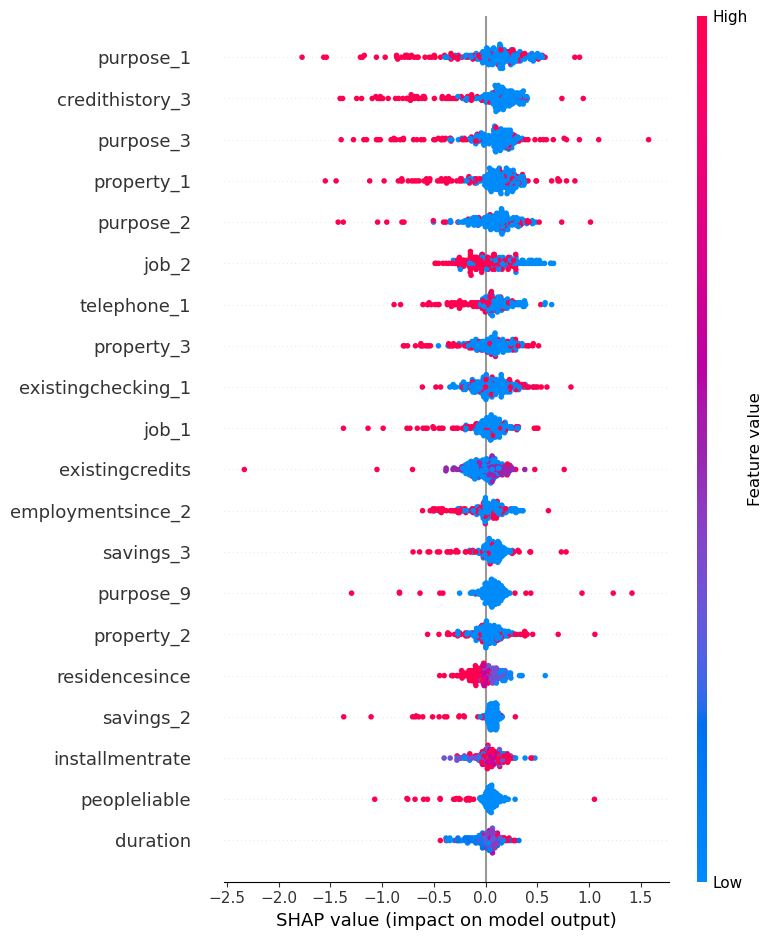

<Figure size 640x480 with 0 Axes>

In [191]:
# SHAP values for both
def shap_show(n_shap_explainer, shap_values):
    if n_shap_explainer == 'LogisticRegression':
        shap_values_sum = shap_values
    else:
        shap_values_sum = shap_values[:,:, 0] + shap_values[:,:,1]
    return shap_values_sum

shap_sum = shap_show(n_shap_explainer, shap_values)

shap.summary_plot(shap_sum, X_test, max_display=20)
plt.savefig('shap_model_smote_svm_summary_plot.png')

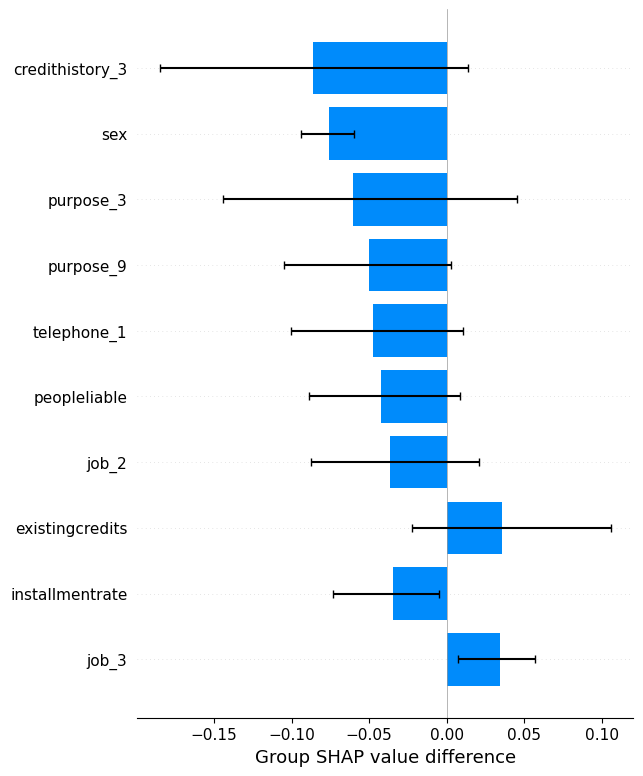

<Figure size 640x480 with 0 Axes>

In [192]:
# Filter male and female SHAP values
mask = (X_test[protected_attribute] == 1) # mask for the advantaged group, output = boolean

shap_male = shap_values[mask]
shap_female = shap_values[~mask]

shap.group_difference_plot(shap_sum, mask, feature_names=X_test.columns, max_display=10)
plt.savefig('shap_model_smo_svm__group_difference_plot_male.png')

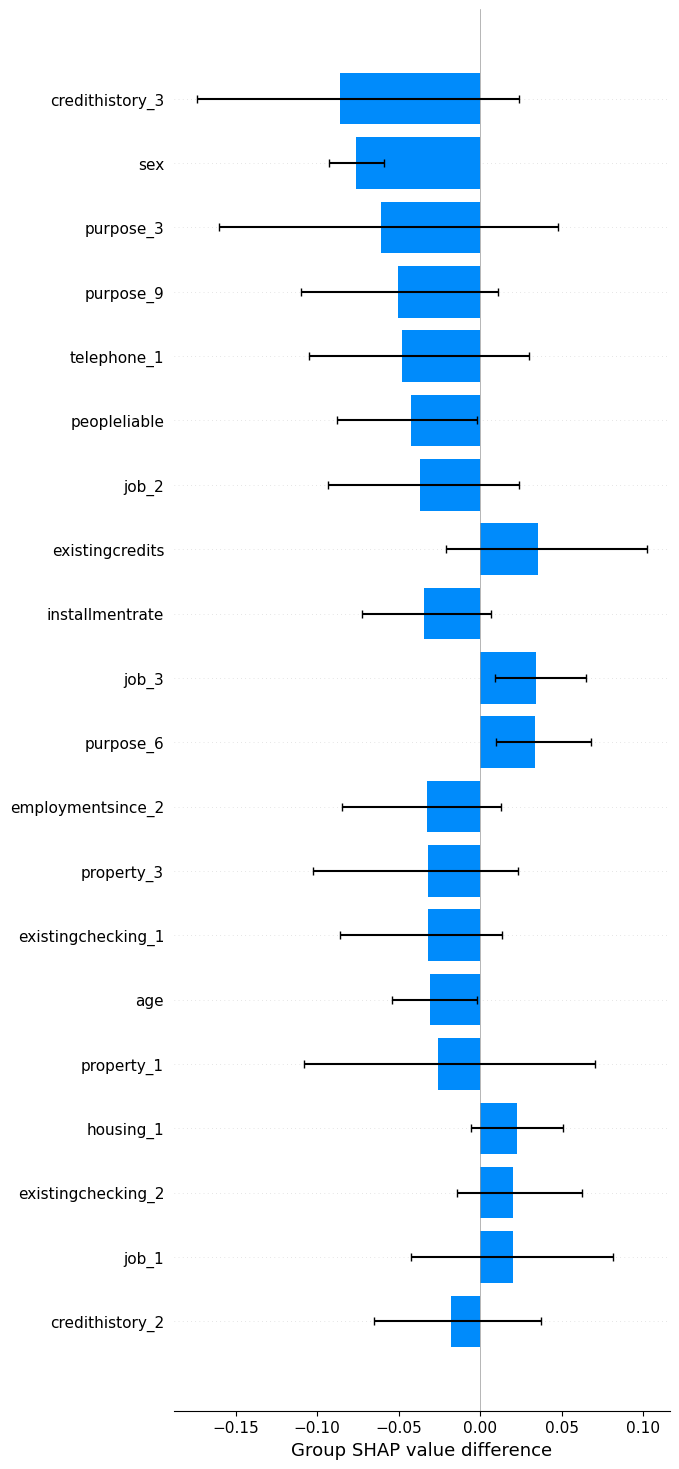

In [193]:
shap.group_difference_plot(shap_sum, mask, feature_names=X_test.columns, max_display=20)

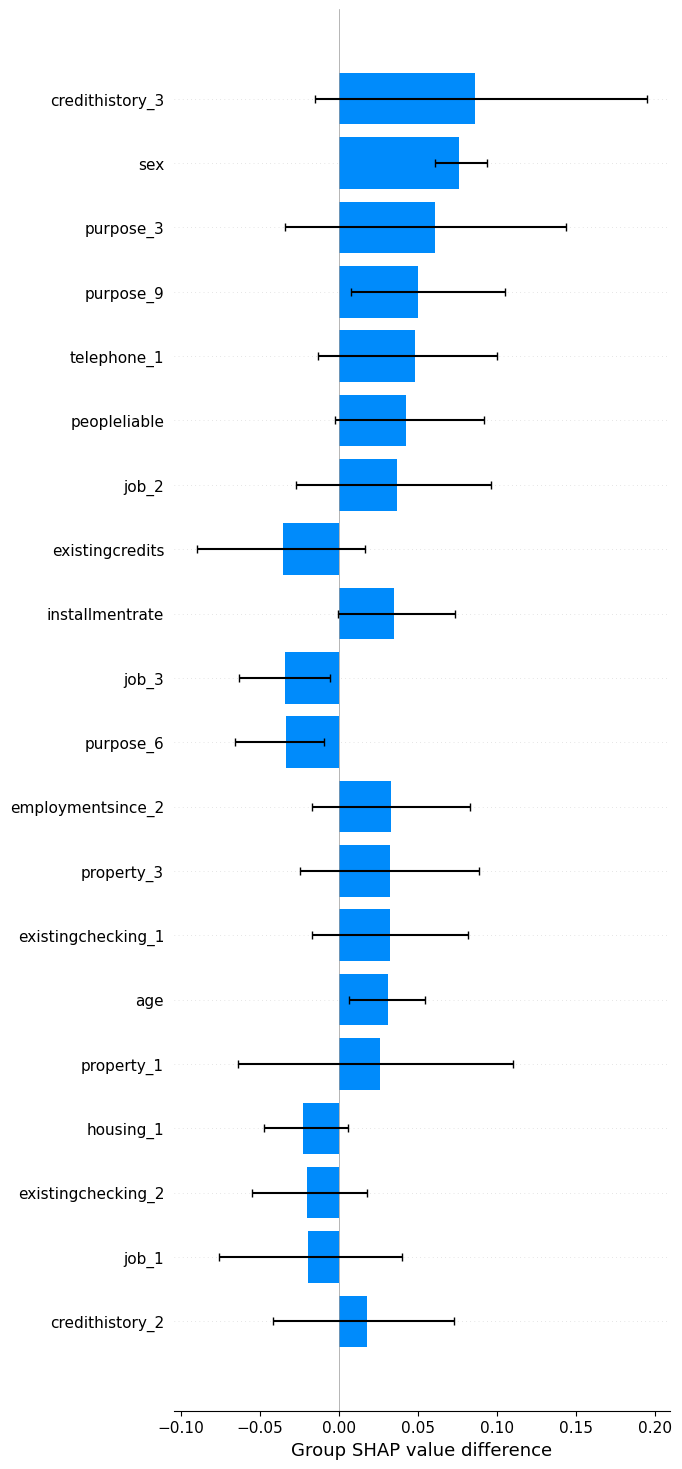

<Figure size 640x480 with 0 Axes>

In [194]:
mask = (X_test[protected_attribute] == 0) # mask for the advantaged group, output = boolean
shap.group_difference_plot(shap_sum, mask, feature_names=X_test.columns, max_display=20)
plt.savefig('shap_model_fairsmo_svm_group_difference_plot_female.png')

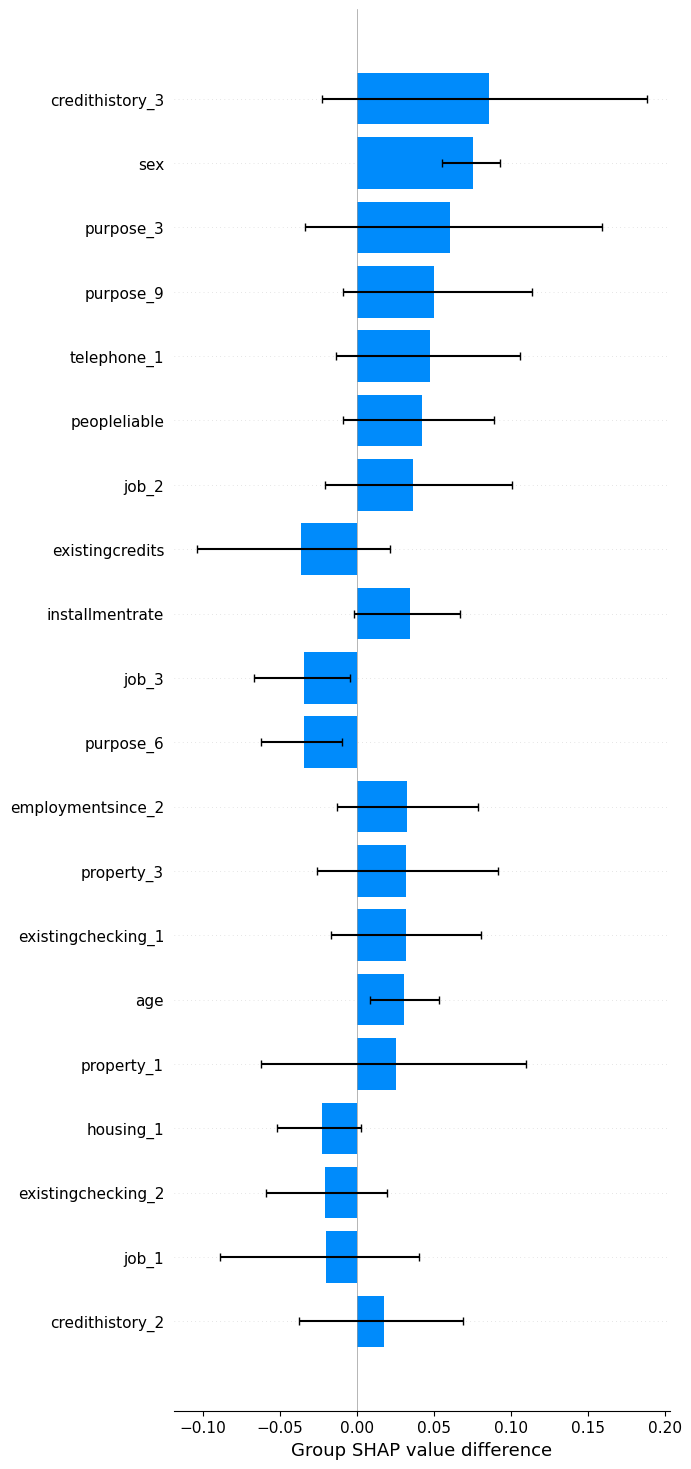

In [195]:
shap.group_difference_plot(shap_sum, mask, feature_names=X_test.columns, max_display=20)

In [196]:
# Separate SHAP values by gender
female_shap_values = shap_values[X_test['sex'] == 0]
male_shap_values = shap_values[X_test['sex'] == 1]

# Calculate average SHAP values for each feature
female_avg_shap = np.mean(female_shap_values, axis=0)
male_avg_shap = np.mean(male_shap_values, axis=0)
print("Average female SHAP score",female_avg_shap.sum())
print("Average male SHAP score:",male_avg_shap.sum())

Average female SHAP score 0.8369713879705775
Average male SHAP score: 0.3596678914797422
